# Data description: 
This hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included. The time period is between Jan 1st, 2010 to Dec 31st, 2014. For more detail check https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data#

Note: This is "Multivariate" Time Series Prediction 

# Workflow:
- Load the Time Series (TS) by Pandas Library
- Prepare the data, i.e. convert the problem to a supervised ML problem
- Split data into train and test sets
- Build and evaluate the RNN model: 
     - Fit the best RNN model
     - Evaluate model by in-sample prediction: Calculate RMSE
- Forecast the future trend: Out-of-sample prediction

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
import random as rn
import math
from pandas import Series, DataFrame, datetime, read_csv, concat
%matplotlib inline

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=5, inter_op_parallelism_threads=5)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


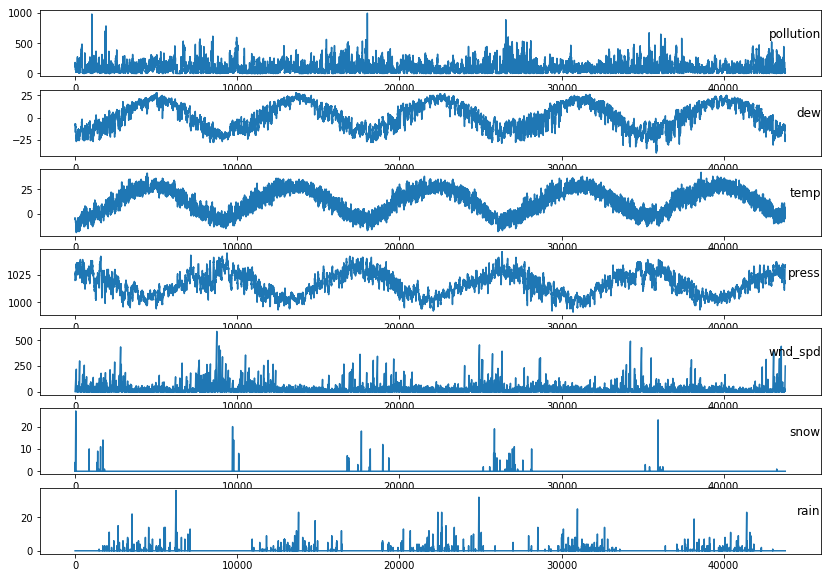

In [3]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
plt.figure(figsize=(14,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# integer encode direction
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
lags = 3
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(scaled, lags, 1)

# drop columns we don't want to predict
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
4   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
5   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
6   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
7   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)   ...     var7(t-1)  var8(t-1)  \
3   0.000000        0.0   0.148893   0.367647   ...      0.000000        0.0   
4   0.000000        0.0   0.159960   0.426471   ...      0.037037        0.0   
5   0.000000        0.0   0.182093   0.485294   ...      0.074074        0.0   
6   0.037037        0.0   0.138833   0.485294   ...      0.111111        0.0   
7   0.074074        0.0   0.109658   0.485294   ...      0.148148        0.0   

    var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)  \
3  0.182093  0.48

In [5]:
# split into train and test sets
values_re = reframed.values
n_train_hours = 365 * 48
train = values_re[:n_train_hours, :]
test = values_re[n_train_hours:, :]

# split into input and outputs
n_obs = lags * n_features
X_train, y_train = train[:, :n_obs], train[:, -n_features]
X_test, y_test = test[:, :n_obs], test[:, -n_features]
print(X_train.shape, y_train.shape)

# reshape input to be 3D [samples, timesteps, features]
X_train_re = X_train.reshape((X_train.shape[0], lags, n_features))
X_test_re = X_test.reshape((X_test.shape[0], lags, n_features))
print(X_train_re.shape, y_train.shape, X_test_re.shape, y_test.shape)

(17520, 24) (17520,)
(17520, 3, 8) (17520,) (26277, 3, 8) (26277,)


Epoch 00052: early stopping


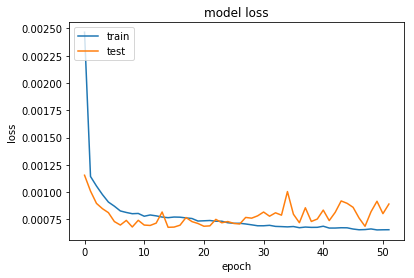

In [6]:
# LSTM RNN model: _________________________________________________________________
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, average, Input, merge, concatenate
from keras.layers.merge import concatenate
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_sample_weight
from keras.layers.normalization import BatchNormalization

# create and fit the LSTM network
mdl = Sequential()
mdl.add(LSTM(50, activation='relu'))
mdl.add(Dense(1))

mdl.compile(loss='mean_squared_error', optimizer='adam')
monitor=EarlyStopping(monitor='loss', min_delta=0.001, patience=50, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="polution_forecast_weights.hdf5", verbose=0, save_best_only=True) # save best model

history=mdl.fit(X_train_re, y_train, epochs=100, batch_size=64, validation_data=(X_test_re, y_test),
                                                 callbacks=[monitor, checkpointer], verbose=0)
mdl.load_weights('polution_forecast_weights.hdf5') # load weights from best model

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
# make a prediction on X_test
y_pred_test = mdl.predict(X_test_re)

# invert scaling for forecast
inv_y_pred_test = scaler.inverse_transform(np.concatenate((y_pred_test, X_test[:, -7:]), axis=1))[:, 0]

inv_y_test = scaler.inverse_transform(np.concatenate((pd.DataFrame(y_test), X_test[:, -7:]), axis=1))[:, 0]

# calculate RMSE
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(inv_y_pred_test, inv_y_test))
print('Test RMSE: %.3f' % rmse)


# make a prediction on X_train
y_pred_train = mdl.predict(X_train_re)

# invert scaling for forecast
inv_y_pred_train = scaler.inverse_transform(np.concatenate((y_pred_train, X_train[:, -7:]), axis=1))[:, 0]

inv_y_train = scaler.inverse_transform(np.concatenate((pd.DataFrame(y_train), X_train[:, -7:]), axis=1))[:, 0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred_train, inv_y_train))
print('Train RMSE: %.3f' % rmse)

Test RMSE: 25.885
Train RMSE: 26.971


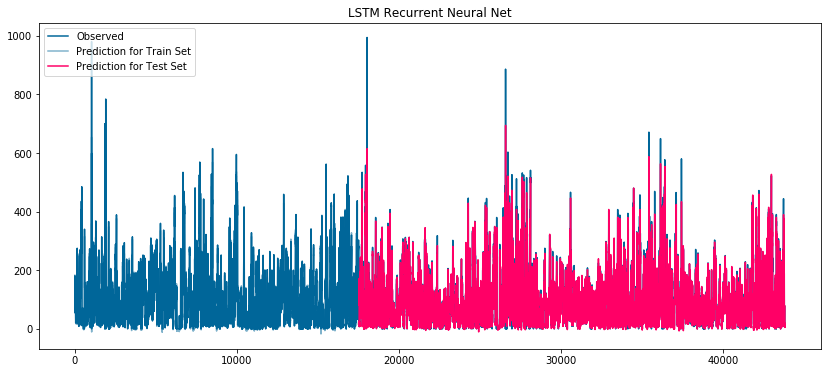

In [8]:
# shift train predictions for plotting
train_predict_plot =np.full(values.shape[0], np.nan)
train_predict_plot[lags:len(y_pred_train)+lags] = inv_y_pred_train
 
# shift test predictions for plotting
test_predict_plot =np.full(values.shape[0], np.nan)
test_predict_plot[len(y_pred_train)+lags:values.shape[0]] = inv_y_pred_test
 
# plot observation and predictions
plt.figure(figsize=(14,6))
plt.plot(dataset['pollution'].values, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='upper left')

plt.title('LSTM Recurrent Neural Net')
plt.show()